In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

22/05/23 13:43:18 WARN Utils: Your hostname, ihyeonmin-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 172.30.1.11 instead (on interface en0)
22/05/23 13:43:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/23 13:43:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/23 13:43:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/23 13:43:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/05/23 13:43:20 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [5]:
trip_files = "/Users/ihyeonmin/Desktop/study/data-engineering/01-spark/data/trips/*"
zone_file = "/Users/ihyeonmin/Desktop/study/data-engineering/01-spark/data/taxi+_zone_lookup.csv"

In [10]:
trips_df = spark.read.parquet(f"file:///{trip_files}",inferSchema=True,header=True)
zone_df = spark.read.csv(f"file:///{zone_file}",inferSchema=True,header=True)

In [11]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zo

In [12]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [39]:
query="""
SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM
    trips t
    LEFT JOIN
        zone pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON
        t.DOLocationID = dz.LocationID
"""
comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")

In [40]:
comb_df.printSchema()

root
 |-- vendor_id: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [41]:
spark.sql("SELECT pickup_date, pickup_time from comb where pickup_time > 0 ORDER BY pickup_date").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2003-01-01|          8|
| 2003-01-05|         16|
| 2004-04-04|         13|
| 2009-01-01|         13|
| 2009-01-01|          9|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2009-01-01|          9|
| 2009-01-01|          9|
| 2009-01-01|          9|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2009-01-01|          9|
| 2009-01-01|         10|
| 2009-01-01|         11|
| 2009-01-01|         11|
| 2009-01-01|          9|
| 2009-01-01|          8|
| 2009-01-01|         12|
| 2009-01-01|         10|
+-----------+-----------+
only showing top 20 rows



In [42]:
spark.sql("SELECT pickup_date, pickup_time from comb where pickup_date < '2020-12-31'").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|         12|
| 2009-01-02|          1|
| 2009-01-01|         20|
| 2009-01-01|         21|
| 2009-01-01|         21|
| 2009-01-01|          8|
| 2009-01-01|          8|
| 2009-01-01|          9|
| 2009-01-01|          9|
| 2009-01-01|          9|
| 2009-01-01|         10|
| 2009-01-01|          9|
| 2009-01-01|          9|
| 2009-01-02|          1|
| 2009-01-02|          1|
| 2009-01-01|          9|
| 2009-01-01|          9|
| 2009-01-01|          9|
| 2009-01-02|          4|
| 2009-01-02|          4|
+-----------+-----------+
only showing top 20 rows



In [43]:
comb_df.select("total_amount").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          15000936|
|   mean| 18.75540051097825|
| stddev|145.74310219085984|
|    min|            -647.8|
|    max|          398469.2|
+-------+------------------+



In [44]:
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000936|
|   mean|6.628556730059906|
| stddev|671.7240645480989|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [45]:
query = """
SELECT
    DATE_TRUNC('MM',c.pickup_date) AS month,
    COUNT(*) AS trips
FROM
    comb c
GROUP BY
    month
ORDER BY
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|  49452|
|2021-07-01 00:00:00|2825121|
|2021-06-01 00:00:00|2813017|
|2021-05-01 00:00:00|2522860|
|2021-04-01 00:00:00|2156143|
|2021-03-01 00:00:00|1910234|
|2021-02-01 00:00:00|1368619|
|2021-01-01 00:00:00|1355332|
|2020-12-01 00:00:00|      1|
|2009-01-01 00:00:00|    137|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      2|
+-------------------+-------+



In [46]:
# Data Cleaning
query = """
SELECT
    *
FROM
    comb c
WHERE
    c.total_amount < 5000
    AND c.total_amount > 0
    AND c.trip_distance < 100
    AND c.passenger_count < 4
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""
cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [47]:
cleaned_df.describe().show()

+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|summary|          vendor_id|       pickup_time|     dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|       tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|  count|           13253642|          13253642|         13253642|          13253642|          13253642|          13253642|          13253642|           13253642|          13253642|           13253642|            13253642|            13253642|
|   mean| 1.670776530707

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [50]:
query = """
SELECT
    c.pickup_date,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date
"""
pd_df=spark.sql(query).toPandas()

<AxesSubplot:xlabel='pickup_date', ylabel='trips'>

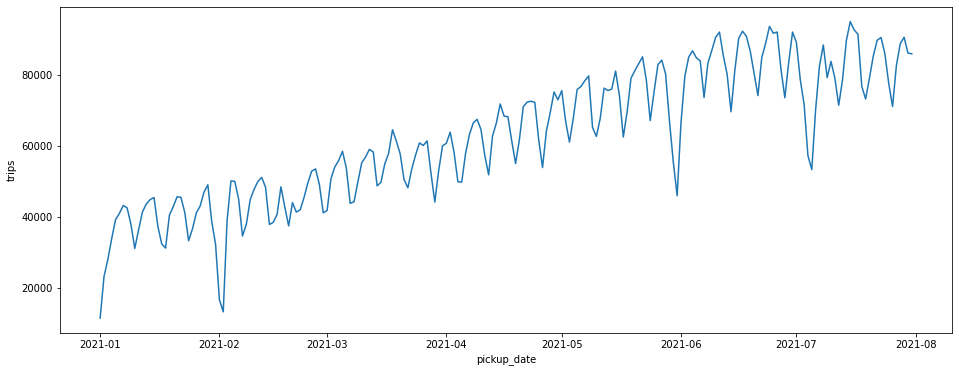

In [54]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x="pickup_date",y="trips",data=pd_df)

In [57]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date,'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()

In [63]:
data=pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data["day_of_week"].replace(
{
    "Sunday":0,
    "Monday":1,
    "Tuesday":2,
    "Wednesday":3,
    "Thursday":4,
    "Friday":5,
    "Saturday":6,
    
})

In [64]:
data.sort_values(by="sort_dow",inplace=True)

<AxesSubplot:xlabel='day_of_week', ylabel='trips'>

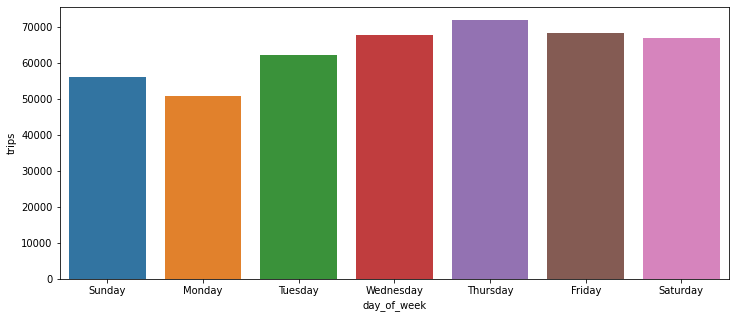

In [66]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="day_of_week",y="trips",data=data)

In [67]:
def get_weekday():
    import calendar
    return calendar.day_name[data.weekday()]

spark.udf.register("get_weekday",get_weekday)

<function __main__.get_weekday()>

In [68]:
query = """
    SELECT
    c.pickup_date,
    get_weekday(c.pickup_date) AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""

In [71]:
payment_type_to_string = {
    1:"Credit Card",
    2:"Cash",
    3:"No Charge",
    4:"Dispute",
    5:"Unknown",
    6:"Voided Trip",
}

def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type",parse_payment_type)

22/05/23 14:33:30 WARN SimpleFunctionRegistry: The function parse_payment_type replaced a previously registered function.


<function __main__.parse_payment_type(payment_type)>

In [72]:
query = """
SELECT
    parse_payment_type(payment_type),
    count(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
    
FROM
    cleaned
GROUP BY
    payment_type
"""
spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10084721|12.212396654303518|10.793059507387618|
|                       No Charge|   58394|11.927290988800209|15.041269068746262|
|                            Cash| 3087063|11.978198702132051|11.473206859706206|
|                         Dispute|   23463|12.639303158163921|14.154693719632085|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+

